# Trabalho de casa 01: Método dos vizinhos mais próximos ($k$-NN)

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** O código abaixo carrega o dataset MNIST, que consiste em imagens de dígitos entre $0$ e $9$. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 5) e reporte a acurácia para cada valor de $k$. Lembre que a acurácia é o percentual de amostras classificadas corretamente. Notavelmente, as entradas do MNIST tem dimensão relativamente alta (64). Plote uma imagem com a variância amostral dos pixels das imagens e comente. Também mostre as imagens classificadas de maneira errônea e comente.

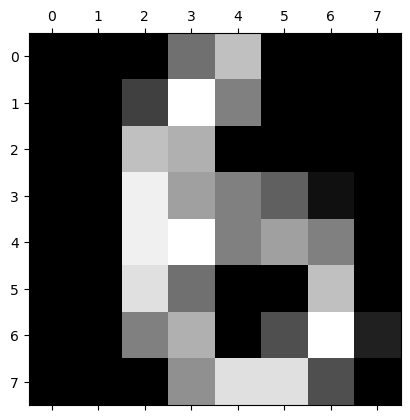

In [148]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)

@dataclass
class Dataset:
    features_train: np.ndarray
    features_test: np.ndarray
    labels_train: np.ndarray
    labels_test: np.ndarray

# Import dataset and separate train/test subsets
mnist = Dataset(*train_test_split(
    *load_digits(return_X_y=True),
    random_state=SEED,
))

# Notice that, in the MNIST dataset, the images are already flattened, i.e., are
# represented as 64-dimensional vectors, not as 8 by 8 matrices.

# To plot one of them, you should reshape it back into (8, 8)
plt.matshow(mnist.features_test[0].reshape(8, 8))
plt.gray()
plt.show()

In [149]:
x_train = mnist.features_train
x_test = mnist.features_test
y_train = mnist.labels_train
y_test = mnist.labels_test

k_values = range(1, 6)

In [150]:
# Calcula a porcentagem de acertos
def get_accuracy(y_test: np.ndarray, y_pred: np.ndarray) -> float: 
    correct = np.sum(y_test == y_pred)
    return correct / len(y_test)


class KNeighborsClassifier:
    def __init__(self, k: int) -> None:
        self.k = k

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        y_pred = []
        for x in X_test:
            # Calcula a distância euclidiana entre x e cada ponto de x_train
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            # np.argpartition retorna os índices dos k menores valores de distances
            nearest = self.y_train[np.argpartition(distances, self.k)[:self.k]]
            # np.bincount retorna o número de ocorrências de cada valor em nearest e argmax retorna o índice do valor mais frequente
            y_pred.append(np.bincount(nearest).argmax())
        return np.array(y_pred)

    def score(self, X_test: np.ndarray, y_test: np.ndarray) -> float:
        y_pred = self.predict(X_test)
        return get_accuracy(y_test, y_pred)

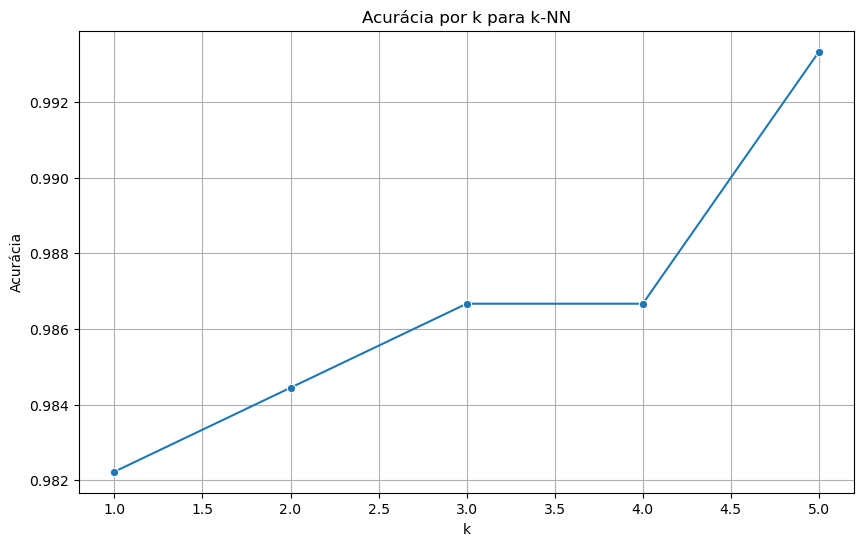

In [151]:
accuracies = []
# Treina e avalia o k-NN para cada valor de k
for k in k_values:
    KNN = KNeighborsClassifier(k)
    KNN.fit(x_train, y_train)  # Treina o modelo com o conjunto de treino
    y_pred = KNN.predict(x_test)  # Faz previsões com o conjunto de teste
    accuracy = get_accuracy(y_test, y_pred)
    accuracies.append(accuracy)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=accuracies, marker='o')
plt.title('Acurácia por k para k-NN')
plt.xlabel('k')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

In [152]:
for i, accuracy in enumerate(accuracies, start=1):
    print(f'Acurácia k = {i}: {accuracy:.3%}')

Acurácia k = 1: 98.222%
Acurácia k = 2: 98.444%
Acurácia k = 3: 98.667%
Acurácia k = 4: 98.667%
Acurácia k = 5: 99.333%


A seguir, vamos plotar a variância amostral dos pixels das imagens: $\frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2$, onde $x_i$ é o valor do pixel $i$ e $\bar{x}$ é a média dos valores dos pixels.

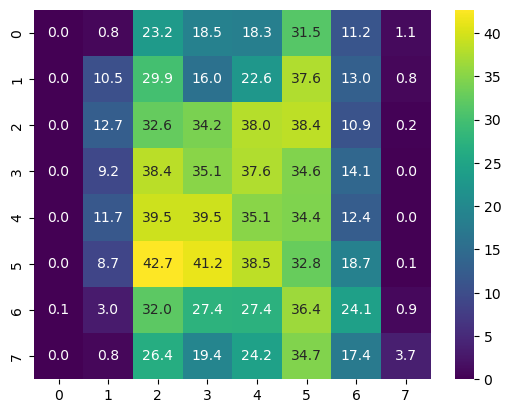

In [153]:
# Calculate the sample variance of each pixel
pixel_variances = np.var(mnist.features_train, axis=0)
image_variances = pixel_variances.reshape(8, 8)
# Plot
sns.heatmap(image_variances, annot=True, fmt=".1f", cmap='viridis')
plt.show()

Podemos ver que a variância dos pixels é maior no centro da imagem, o que faz sentido, já que é onde a maioria dos dígitos estão localizados. Nas extremidades há menos variação, já que é onde a maioria dos dígitos não estão presentes. Ou seja, nas laterais onde vemos variância 0, quer dizer que a maioria dos pixels são iguais, ou seja, são pretos. Agora para encontrar as imagens classificadas corretamente em $k = 5$, basta encontrar os índices onde a predição é diferente ao valor real.

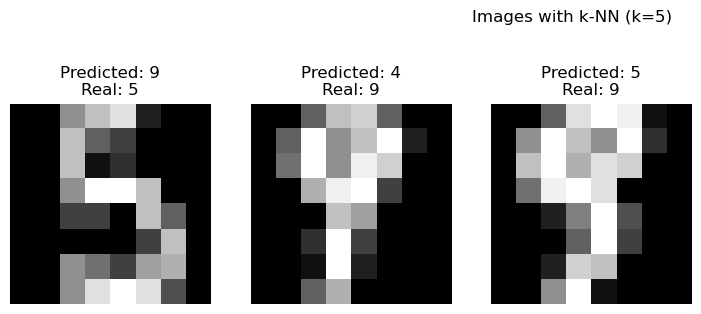

In [154]:
# Encontra os índices das imagens classificadas incorretamente
errors = np.where(y_pred != y_test)[0] # (k=5)

# Plot 
plt.figure(figsize=(15, 4))
for i, index in enumerate(errors):  # Showing all errors
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[index].reshape(8, 8), cmap='gray') 
    plt.title(f"Predicted: {y_pred[index]}\nReal: {y_test[index]}")
    plt.axis('off')

plt.suptitle('Images with k-NN (k=5)')
plt.show()

**Exercício 02.** O código abaixo carrega o dataset "two moons", que consiste de amostras bidimensionais divididas em duas classes. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 10). Plote a superfície de decisão para cada valor de $k$. Como $k$ influencia na suavidade dessas superfícies?

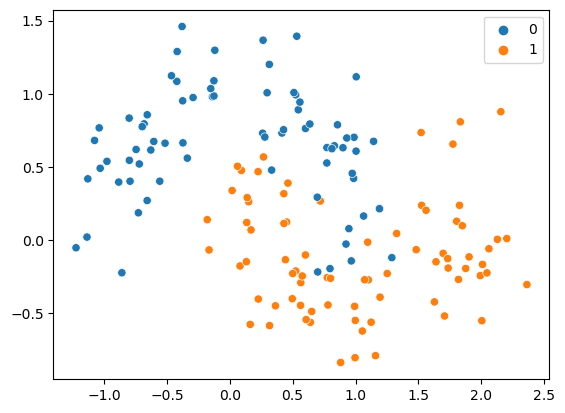

In [155]:
# Import dataset and separate train/test subsets
moon = Dataset(*train_test_split(
    *make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=SEED),
    random_state=SEED,
))

# Let's also plot the moon dataset, for you to take a look at it.
sns.scatterplot(
    x=moon.features_train[:, 0],
    y=moon.features_train[:, 1],
    hue=moon.labels_train,
)
plt.show()

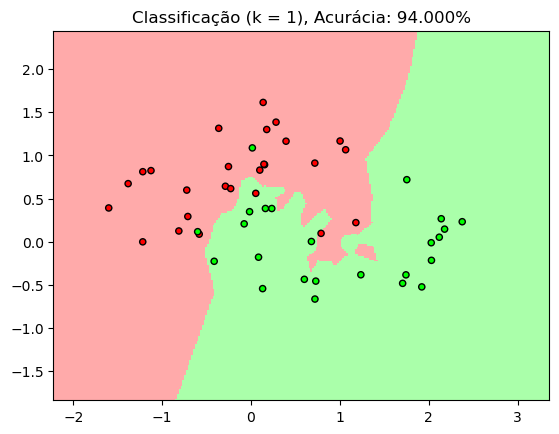

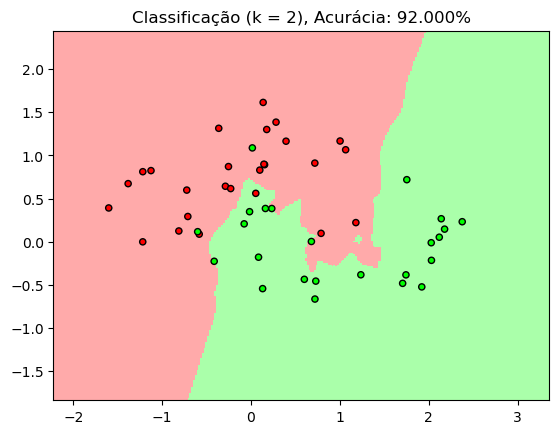

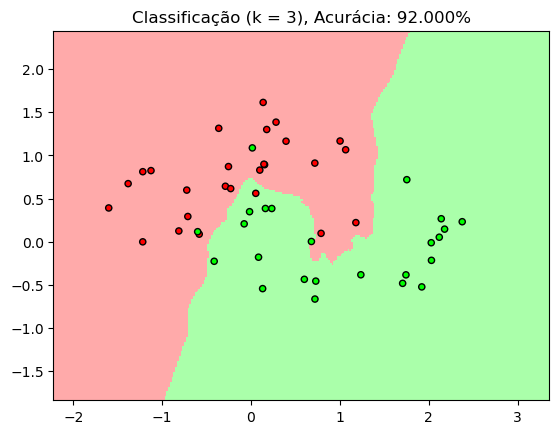

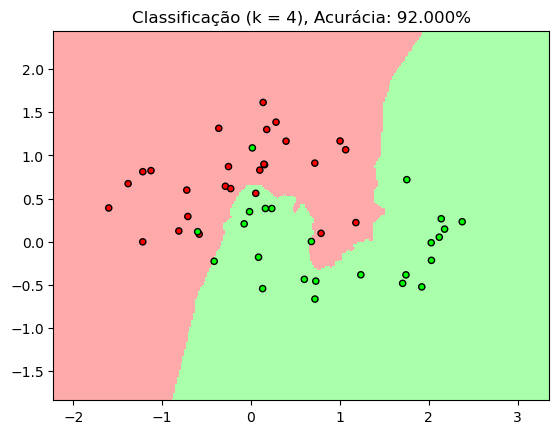

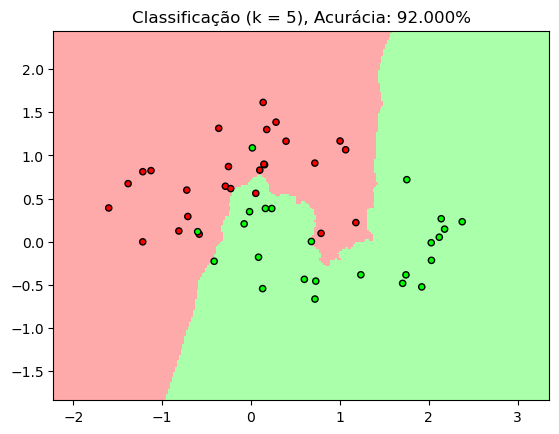

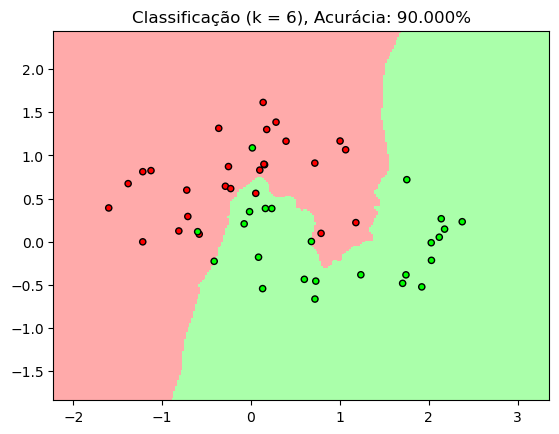

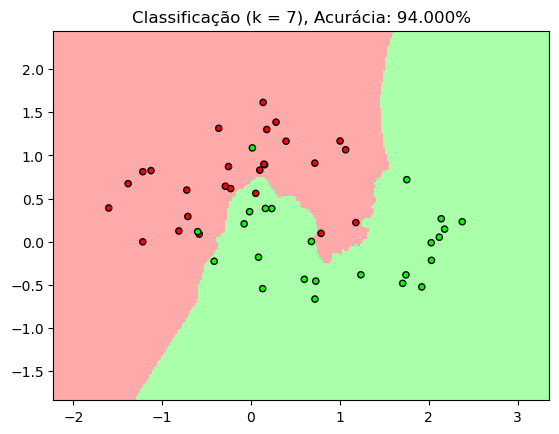

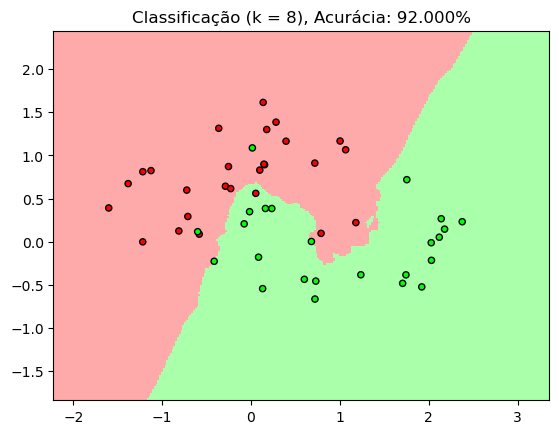

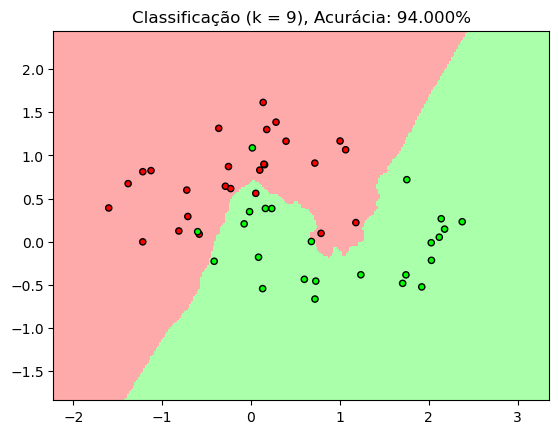

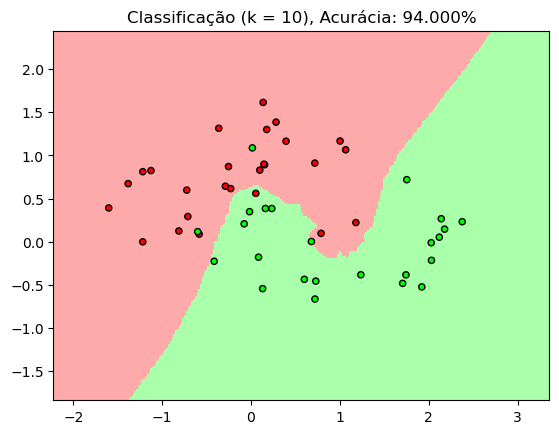

In [161]:
accuracies = []
k_values = range(1, 11)

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Grid
x_min, x_max = moon.features_train[:, 0].min() - 1, moon.features_train[:, 0].max() + 1
y_min, y_max = moon.features_train[:, 1].min() - 1, moon.features_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

# k-NN classifier for each k value
for k in k_values:
    KNN = KNeighborsClassifier(k)
    KNN.fit(moon.features_train, moon.labels_train) # Train the model
    Z = KNN.predict(np.c_[xx.ravel(), yy.ravel()]) # Predictions
    Z = Z.reshape(xx.shape)
    accuracy = get_accuracy(moon.labels_test, KNN.predict(moon.features_test))
    
    # Plot the decision boundary
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot the training points
    plt.scatter(moon.features_test[:, 0], moon.features_test[:, 1], c=moon.labels_test, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Classificação (k = {k}), Acurácia: {accuracy:.3%}")
    
plt.show()

O aumento de $k$ pode reduzir a variância do modelo, mas aumenta o viés. Isso ocorre porque, ao aumentar $k$, o modelo considera mais pontos para fazer a previsão, o que pode levar a uma classificação mais genérica. Por outro lado, ao diminuir $k$, o modelo considera menos pontos, o que pode levar a uma classificação mais específica.

# Exercícios de "papel e caneta"

**Exercício 1.** Como mencionado na nota de aula, é comum *normalizar* os dados antes de utilizar algoritmos de ML. Seja $\mathbf{x} \in \mathcal{X}$ um ponto arbitrário do nosso conjunto de dados (antes de normalização). Deixe também que $\mathcal{V}_k(\mathbf{x})$ seja o conjunto dos $k$ vizinhos mais próximos de $\mathbf{x}$ dentre nossas observações. É possível que $\mathcal{V}_k(\mathbf{x})$ mude caso normalizemos os dados? Prove.

Resposta: O Knn computa as distâncias entre os pontos utilizando distância euclidiana, ou seja, se temos dois pontos arbitrários $a = (a_1, a_2, ..., a_n)$ e $b = (b_1, b_2, ..., b_n)$ em um espaço n-dimensional, a distância entre eles é dada por $\sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}$. Essa distância é invariante a translações e rotações, mas não é invariante a escala. Se normalizarmos os dados, estamos mudando a escala dos pontos, e portanto, a distância entre eles. Portanto, é possível que $\mathcal{V}_k(\mathbf{x})$ mude caso normalizemos os dados.

**Exercício 2.** Suponha que estamos usando $k$-NN equipado com distância Mahalanobis $d_M$ (veja Eq. 3.5 das notas de aula). Suponha ainda que $\Sigma$ é a matrix de covariância real dos dados (i.e., do vetor aleatório $\mathbf{x} \sim \mathbb{P}_\mathbf{x}$), ao invés de uma estimativa baseada em amostras. Existe uma transformação $g$ tal que $d_M(a, b) = \|g(a) - g(b) \|_2$? Mostre a transformação e derive a matriz de covariância de $z = g(\mathbf{x})$. 

Resposta: Sim, existe uma transformação $g$ tal que $d_M(a, b) = \|g(a) - g(b) \|_2$. Dado que:

$$\|g(a) - g(b) \|_2 = \sqrt{\sum_{i} (g(a_i) - g(b_i))^2}$$

$$d_M(a, b) = \sqrt{(a - b)^T \Sigma^{-1} (a - b)}$$

Temos:

$$\sqrt{(a - b)^T \Sigma^{-1} (a - b)} = \sqrt{\sum_{i} (g(a_i) - g(b_i))^2}$$

$$\sqrt{(a - b)^T \Sigma^{-1} (a - b)} = \sqrt{(g(a) - g(b))^T (g(a) - g(b))}$$

Propriedade: Uma matriz é Hermitian se e somente se essa matriz tem apenas valores reais e é simétrica. 

Teorema: Se $A$ é uma matriz Hermitian, é possível decompor $A$ em $A = LL^T$, onde $L$ é uma matriz triangular inferior. 

A matriz de covariância é semi-positiva definida, simétrica e invertível, portanto, podemos decompor $\Sigma$ em $\Sigma = LL^T$, onde $L$ é uma matriz triangular inferior. 

$$\sqrt{(a - b)^T (LL^T)^{-1} (a - b)} = \sqrt{(g(a) - g(b))^T (g(a) - g(b))}$$

$$(a - b)^T (LL^T)^{-1} (a - b) = (g(a) - g(b))^T (g(a) - g(b))$$

$$(a - b)^T (L^{-1})^{T}L^{-1} (a - b) = (g(a) - g(b))^T (g(a) - g(b))$$

$$((a - b) (L^{-1}))^T (L^{-1} (a - b)) = (g(a) - g(b))^T (g(a) - g(b))$$

$$(L^{-1}(a) - L^{-1}(b))^T  (L^{-1}(a) - L^{-1}(b)) = (g(a) - g(b))^T (g(a) - g(b))$$

Podemos concluír que $g(a) = L^{-1}(a)$. Agora para a matriz de covariância de $z = g(\mathbf{x})$, temos:


$$\Sigma_z = E[(z - E[z])([z] - E[z])^T]$$
Substituindo $z = g(\mathbf{x})$,
$$\Sigma_z = E[(L^{-1}x - E[L^{-1}x])([L^{-1}x] - E[L^{-1}x])^T]$$

Como $L^{-1}$ não depende de $x$, $E[L^{-1}x] = L^{-1}E[x]$.
$$\Sigma_z = L^{-1}\underbrace{E[(x - L^{-1}E[x])(x - L^{-1}E[x])^T]}_{\Sigma_x}(L^{-1})^T$$
$$\Sigma_z = L^{-1}\Sigma_x(L^{-1})^T$$
$$\Sigma_z = \underbrace{L^{-1}L}_{I}L^T(L^{-1})^T$$
$$\Sigma_z = L^{-1}L^T(L^{-1})^T$$
$$\Sigma_z = (L^{-1}L)^T = I^T$$
$$\Sigma_z = I$$
